In [83]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# Install python-control pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install control

import control as ct

  Using cached https://files.pythonhosted.org/packages/e6/fc/5889757c4c70c552f56fddc8fbdcab565475686cdebdfa1806a9d54cd53b/matplotlib-3.2.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/62/20/4d43e141b5bc426ba38274933ef8e76e85c7adea2c321ecf9ebf7421cedf/numpy-1.18.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/dc/29/162476fd44203116e7980cfbd9352eef9db37c49445d1fec35509022f6aa/scipy-1.4.1-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f8/a1/5742b56282449b1c0968197f63eae486eca2c35dcd334bab75ad524e0de1/kiwisolver-1.1.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/f7/d2/e07d3ebb2bd7af696440ce7e754c59dd546ffe1bbe732c8ab68b9c834e61/cycler-0.10.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/5d/bc/1e58593167fade7b544bfe9502a26dc860940a79ab306e651e7f13be68c2/pyparsing-2.4.6-py2.py3-none-any.whl
  Usi

# Section 4.1: Cruise control modeling and control

## Vehicle model: vehicle()
To develop a mathematical model we start with a force balance for
the car body. Let v be the speed of the car, m the total mass
(including passengers), F the force generated by the contact of the
wheels with the road, and Fd the disturbance force due to gravity,
friction, and aerodynamic drag.

In [59]:
def vehicle_update(t, x, u, params={}):
    """Vehicle dynamics for cruise control system.

    Parameters
    ----------
    x : array
         System state: car velocity in m/s
    u : array
         System input: [throttle, gear, road_slope], where throttle is
         a float between 0 and 1, gear is an integer between 1 and 5,
         and road_slope is in rad.

    Returns
    -------
    float
        Vehicle acceleration

    """
    from math import copysign, sin
    sign = lambda x: copysign(1, x)         # define the sign() function
    
    # Set up the system parameters
    m = params.get('m', 1600.)
    g = params.get('g', 9.8)
    Cr = params.get('Cr', 0.01)
    Cd = params.get('Cd', 0.32)
    rho = params.get('rho', 1.3)
    A = params.get('A', 2.4)
    alpha = params.get(
        'alpha', [40, 25, 16, 12, 10])      # gear ratio / wheel radius

    # Define variables for vehicle state and inputs
    v = x[0]                           # vehicle velocity
    throttle = np.clip(u[0], 0, 1)     # vehicle throttle
    gear = u[1]                        # vehicle gear
    theta = u[2]                       # road slope

    # Force generated by the engine

    omega = alpha[int(gear)-1] * v      # engine angular speed
    F = alpha[int(gear)-1] * motor_torque(omega, params) * throttle

    # Disturbance forces
    #
    # The disturbance force Fd has three major components: Fg, the forces due
    # to gravity; Fr, the forces due to rolling friction; and Fa, the
    # aerodynamic drag.

    # Letting the slope of the road be \theta (theta), gravity gives the
    # force Fg = m g sin \theta.
    
    Fg = m * g * sin(theta)

    # A simple model of rolling friction is Fr = m g Cr sgn(v), where Cr is
    # the coefficient of rolling friction and sgn(v) is the sign of v (+/- 1) or
    # zero if v = 0.
    
    Fr  = m * g * Cr * sign(v)

    # The aerodynamic drag is proportional to the square of the speed: Fa =
    # 1/\rho Cd A |v| v, where \rho is the density of air, Cd is the
    # shape-dependent aerodynamic drag coefficient, and A is the frontal area
    # of the car.

    Fa = 1/2 * rho * Cd * A * abs(v) * v
    
    # Final acceleration on the car
    Fd = Fg + Fr + Fa
    dv = (F - Fd) / m
    
    return dv

## Engine model: motor_torque

 The force F is generated by the engine, whose torque is proportional to
 the rate of fuel injection, which is itself proportional to a control
 signal 0 <= u <= 1 that controls the throttle position. The torque also
 depends on engine speed omega.

In [60]:
def motor_torque(omega, params={}):
    # Set up the system parameters
    Tm = params.get('Tm', 190.)             # engine torque constant
    omega_m = params.get('omega_m', 420.)   # peak engine angular speed
    beta = params.get('beta', 0.4)          # peak engine rolloff

    return np.clip(Tm * (1 - beta * (omega/omega_m - 1)**2), 0, None)

In [61]:
# Define the input/output system for the vehicle
vehicle = ct.NonlinearIOSystem(
    vehicle_update, None, name='vehicle',
    inputs = ('u', 'gear', 'theta'), outputs = ('v'), states=('v'))

<IPython.core.display.Javascript object>


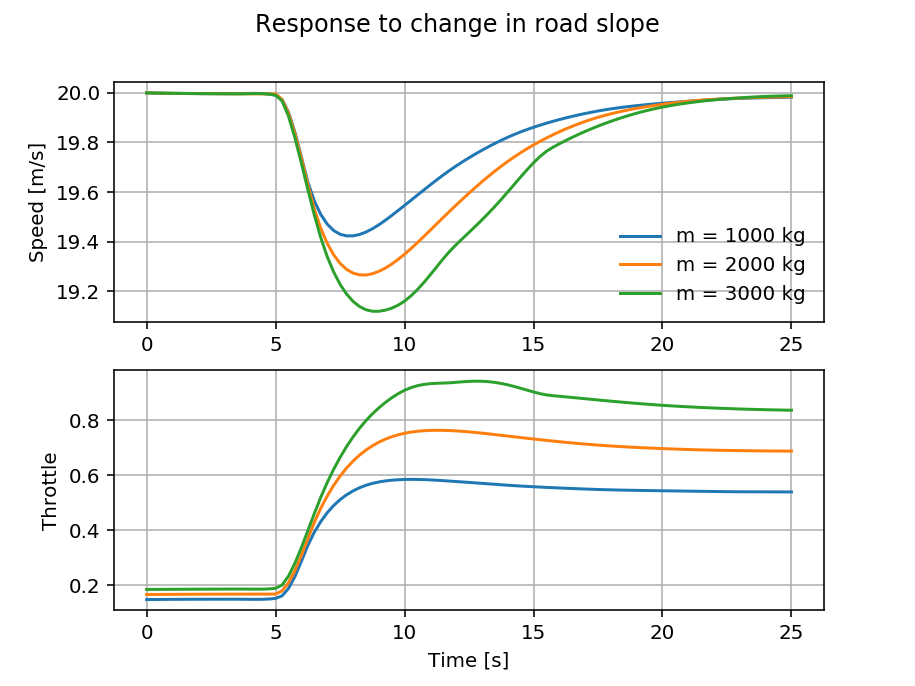

Text(0.5, 0, 'Time [s]')

In [69]:
# Figure 1.11: A feedback system for controlling the speed of a vehicle. In
# this example, the speed of the vehicle is measured and compared to the
# desired speed.  The controller is a PI controller represented as a transfer
# function.  In the textbook, the simulations are done for LTI systems, but
# here we simulate the full nonlinear system.

# Construct a PI controller with rolloff, as a transfer function
Kp = 0.5                        # proportional gain
Ki = 0.1                        # integral gain
control_tf = ct.tf2io(
    ct.TransferFunction([Kp, Ki], [1, 0.01*Ki/Kp]),
    name='control', inputs='u', outputs='y')

# Construct the closed loop control system
# Inputs: vref, gear, theta
# Outputs: v (vehicle velocity)
cruise_tf = ct.InterconnectedSystem(
    (control_tf, vehicle), name='cruise',
    connections = (
        ('control.u', '-vehicle.v'),
        ('vehicle.u', 'control.y')),
    inplist = ('control.u', 'vehicle.gear', 'vehicle.theta'),
    inputs = ('vref', 'gear', 'theta'),
    outlist = ('vehicle.v', 'vehicle.u'),
    outputs = ('v', 'u'))

# Define the time and input vectors
T = np.linspace(0, 25, 101)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

# Now simulate the effect of a hill at t = 5 seconds
plt.figure()
plt.suptitle('Response to change in road slope')
vel_axes = plt.subplot(2, 1, 1)
inp_axes = plt.subplot(2, 1, 2)
theta_hill = np.array([
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T])

for m in (1200, 1600, 2000):
    # Compute the equilibrium state for the system
    X0, U0 = ct.find_eqpt(
        cruise_tf, [0, vref[0]], [vref[0], gear[0], theta0[0]], 
        iu=[1, 2], y0=[vref[0], 0], iy=[0], params={'m':m})

    t, y = ct.input_output_response(
        cruise_tf, T, [vref, gear, theta_hill], X0, params={'m':m})

    # Plot the velocity
    plt.sca(vel_axes)
    plt.plot(t, y[0])

    # Plot the input
    plt.sca(inp_axes)
    plt.plot(t, y[1])

# Add labels to the plots
plt.sca(vel_axes)
plt.grid()
plt.ylabel('Speed [m/s]')
plt.legend(['m = 1000 kg', 'm = 2000 kg', 'm = 3000 kg'], frameon=False)

plt.sca(inp_axes)
plt.grid()
plt.ylabel('Throttle')
plt.xlabel('Time [s]')

<IPython.core.display.Javascript object>


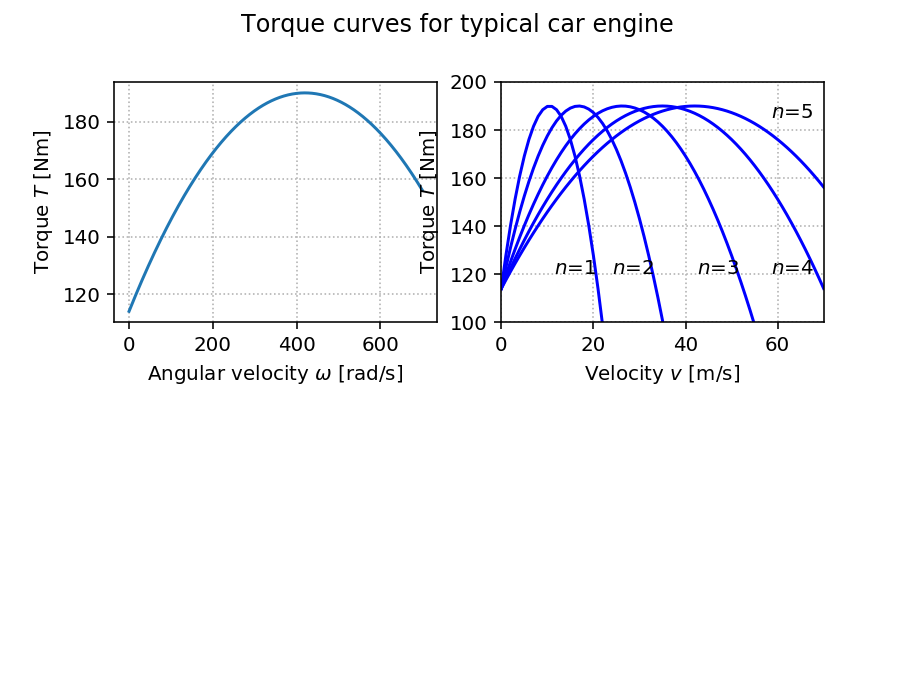

In [71]:
# Figure 4.2: Torque curves for a typical car engine. The graph on the
# left shows the torque generated by the engine as a function of the
# angular velocity of the engine, while the curve on the right shows
# torque as a function of car speed for different gears.

plt.figure()
plt.suptitle('Torque curves for typical car engine')

# Figure 4.2a - single torque curve as function of omega
omega_range = np.linspace(0, 700, 701)
plt.subplot(2, 2, 1)
plt.plot(omega_range, [motor_torque(w) for w in omega_range])
plt.xlabel('Angular velocity $\omega$ [rad/s]')
plt.ylabel('Torque $T$ [Nm]')
plt.grid(True, linestyle='dotted')

# Figure 4.2b - torque curves in different gears, as function of velocity
plt.subplot(2, 2, 2)
v_range = np.linspace(0, 70, 71)
alpha = [40, 25, 16, 12, 10]
for gear in range(5):
    omega_range = alpha[gear] * v_range
    plt.plot(v_range, [motor_torque(w) for w in omega_range],
             color='blue', linestyle='solid')

# Set up the axes and style
plt.axis([0, 70, 100, 200])
plt.grid(True, linestyle='dotted')

# Add labels
plt.text(11.5, 120, '$n$=1')
plt.text(24, 120, '$n$=2')
plt.text(42.5, 120, '$n$=3')
plt.text(58.5, 120, '$n$=4')
plt.text(58.5, 185, '$n$=5')
plt.xlabel('Velocity $v$ [m/s]')
plt.ylabel('Torque $T$ [Nm]')

plt.show(block=False)

<IPython.core.display.Javascript object>


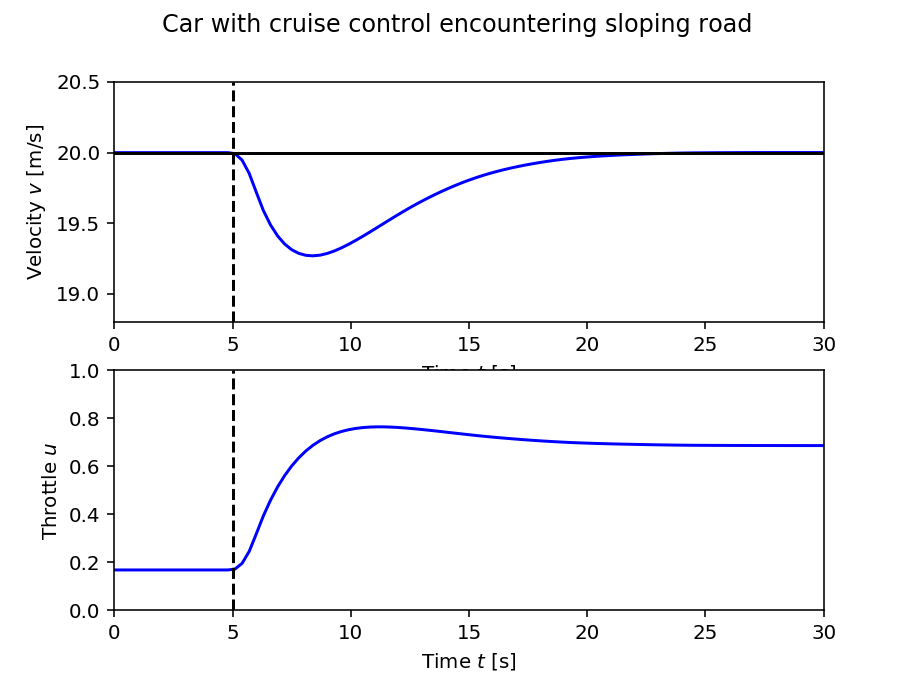

In [72]:
# Figure 4.3: Car with cruise control encountering a sloping road

# PI controller model: control_pi()
#
# We add to this model a feedback controller that attempts to regulate the
# speed of the car in the presence of disturbances. We shall use a
# proportional-integral controller

def pi_update(t, x, u, params={}):
    # Get the controller parameters that we need
    ki = params.get('ki', 0.1)
    kaw = params.get('kaw', 2)  # anti-windup gain

    # Assign variables for inputs and states (for readability)
    v = u[0]                    # current velocity
    vref = u[1]                 # reference velocity
    z = x[0]                    # integrated error

    # Compute the nominal controller output (needed for anti-windup)
    u_a = pi_output(t, x, u, params)

    # Compute anti-windup compensation (scale by ki to account for structure)
    u_aw = kaw/ki * (np.clip(u_a, 0, 1) - u_a) if ki != 0 else 0

    # State is the integrated error, minus anti-windup compensation
    return (vref - v) + u_aw

def pi_output(t, x, u, params={}):
    # Get the controller parameters that we need
    kp = params.get('kp', 0.5)
    ki = params.get('ki', 0.1)

    # Assign variables for inputs and states (for readability)
    v = u[0]                    # current velocity
    vref = u[1]                 # reference velocity
    z = x[0]                    # integrated error

    # PI controller
    return kp * (vref - v) + ki * z

control_pi = ct.NonlinearIOSystem(
    pi_update, pi_output, name='control',
    inputs = ['v', 'vref'], outputs = ['u'], states = ['z'],
    params = {'kp':0.5, 'ki':0.1})

# Create the closed loop system
cruise_pi = ct.InterconnectedSystem(
    (vehicle, control_pi), name='cruise',
    connections=(
        ('vehicle.u', 'control.u'),
        ('control.v', 'vehicle.v')),
    inplist=('control.vref', 'vehicle.gear', 'vehicle.theta'),
    outlist=('control.u', 'vehicle.v'), outputs=['u', 'v'])

# Figure 4.3b shows the response of the closed loop system.  The figure shows
# that even if the hill is so steep that the throttle changes from 0.17 to
# almost full throttle, the largest speed error is less than 1 m/s, and the
# desired velocity is recovered after 20 s.

# Define a function for creating a "standard" cruise control plot
def cruise_plot(sys, t, y, t_hill=5, vref=20, antiwindup=False,
                linetype='b-', subplots=[None, None]):
    # Figure out the plot bounds and indices
    v_min = vref-1.2; v_max = vref+0.5; v_ind = sys.find_output('v')
    u_min = 0; u_max = 2 if antiwindup else 1; u_ind = sys.find_output('u')

    # Make sure the upper and lower bounds on v are OK
    while max(y[v_ind]) > v_max: v_max += 1
    while min(y[v_ind]) < v_min: v_min -= 1

    # Create arrays for return values
    subplot_axes = list(subplots)

    # Velocity profile
    if subplot_axes[0] is None:
        subplot_axes[0] = plt.subplot(2, 1, 1)
    else:
        plt.sca(subplots[0])
    plt.plot(t, y[v_ind], linetype)
    plt.plot(t, vref*np.ones(t.shape), 'k-')
    plt.plot([t_hill, t_hill], [v_min, v_max], 'k--')
    plt.axis([0, t[-1], v_min, v_max])
    plt.xlabel('Time $t$ [s]')
    plt.ylabel('Velocity $v$ [m/s]')

    # Commanded input profile
    if subplot_axes[1] is None:
        subplot_axes[1] = plt.subplot(2, 1, 2)
    else:
        plt.sca(subplots[1])
    plt.plot(t, y[u_ind], 'r--' if antiwindup else linetype)
    plt.plot([t_hill, t_hill], [u_min, u_max], 'k--')
    plt.axis([0, t[-1], u_min, u_max])
    plt.xlabel('Time $t$ [s]')
    plt.ylabel('Throttle $u$')

    # Applied input profile
    if antiwindup:
        # TODO: plot the actual signal from the process?
        plt.plot(t, np.clip(y[u_ind], 0, 1), linetype)
        plt.legend(['Commanded', 'Applied'], frameon=False)

    return subplot_axes

# Define the time and input vectors
T = np.linspace(0, 30, 101)
vref = 20 * np.ones(T.shape)
gear = 4 * np.ones(T.shape)
theta0 = np.zeros(T.shape)

# Compute the equilibrium throttle setting for the desired speed (solve for x
# and u given the gear, slope, and desired output velocity)
X0, U0, Y0 = ct.find_eqpt(
    cruise_pi, [vref[0], 0], [vref[0], gear[0], theta0[0]],
    y0=[0, vref[0]], iu=[1, 2], iy=[1], return_y=True)

# Now simulate the effect of a hill at t = 5 seconds
plt.figure()
plt.suptitle('Car with cruise control encountering sloping road')
theta_hill = [
    0 if t <= 5 else
    4./180. * pi * (t-5) if t <= 6 else
    4./180. * pi for t in T]
t, y = ct.input_output_response(cruise_pi, T, [vref, gear, theta_hill], X0)
cruise_plot(cruise_pi, t, y)

In [78]:
#
# Example 7.8: State space feedback with integral action
#

# State space controller model: control_sf_ia()
#
# Construct a state space controller with integral action, linearized around
# an equilibrium point.  The controller is constructed around the equilibrium
# point (x_d, u_d) and includes both feedforward and feedback compensation.
#
# Controller inputs: (x, y, r)    system states, system output, reference
# Controller state:  z            integrated error (y - r)
# Controller output: u            state feedback control
#
# Note: to make the structure of the controller more clear, we implement this
# as a "nonlinear" input/output module, even though the actual input/output
# system is linear.  This also allows the use of parameters to set the
# operating point and gains for the controller.

def sf_update(t, z, u, params={}):
    y, r = u[1], u[2]
    return y - r

def sf_output(t, z, u, params={}):
    # Get the controller parameters that we need
    K = params.get('K', 0)
    ki = params.get('ki', 0)
    kf = params.get('kf', 0)
    xd = params.get('xd', 0)
    yd = params.get('yd', 0)
    ud = params.get('ud', 0)

    # Get the system state and reference input
    x, y, r = u[0], u[1], u[2]

    return ud - K * (x - xd) - ki * z + kf * (r - yd)

# Create the input/output system for the controller
control_sf = ct.NonlinearIOSystem(
    sf_update, sf_output, name='control',
    inputs=('x', 'y', 'r'),
    outputs=('u'),
    states=('z'))

# Create the closed loop system for the state space controller
cruise_sf = ct.InterconnectedSystem(
    (vehicle, control_sf), name='cruise',
    connections=(
        ('vehicle.u', 'control.u'),
        ('control.x', 'vehicle.v'),
        ('control.y', 'vehicle.v')),
    inplist=('control.r', 'vehicle.gear', 'vehicle.theta'),
    outlist=('control.u', 'vehicle.v'), outputs=['u', 'v'])

# Compute the linearization of the dynamics around the equilibrium point

# Y0 represents the steady state with PI control => we can use it to
# identify the steady state velocity and required throttle setting.
xd = Y0[1]
ud = Y0[0]
yd = Y0[1]

# Compute the linearized system at the eq pt
cruise_linearized = ct.linearize(vehicle, xd, [ud, gear[0], 0])

# Construct the gain matrices for the system
A, B, C = cruise_linearized.A, cruise_linearized.B[0, 0], cruise_linearized.C
K = 0.5
kf = -1 / (C * np.linalg.inv(A - B * K) * B)

<IPython.core.display.Javascript object>


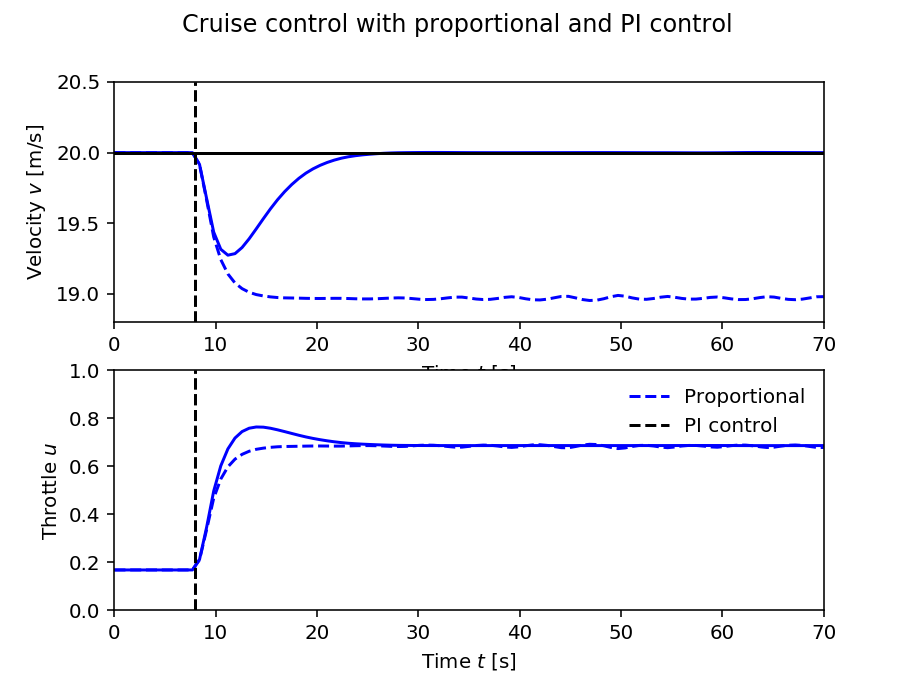

In [79]:
# Response of the system with no integral feedback term
plt.figure()
plt.suptitle('Cruise control with proportional and PI control')
theta_hill = [
    0 if t <= 8 else
    4./180. * pi * (t-8) if t <= 9 else
    4./180. * pi for t in T]
t, y = ct.input_output_response(
    cruise_sf, T, [vref, gear, theta_hill], [X0[0], 0],
    params={'K':K, 'kf':kf, 'ki':0.0, 'kf':kf, 'xd':xd, 'ud':ud, 'yd':yd})
subplots = cruise_plot(cruise_sf, t, y, t_hill=8, linetype='b--')

# Response of the system with state feedback + integral action
t, y = ct.input_output_response(
    cruise_sf, T, [vref, gear, theta_hill], [X0[0], 0],
    params={'K':K, 'kf':kf, 'ki':0.1, 'kf':kf, 'xd':xd, 'ud':ud, 'yd':yd})
cruise_plot(cruise_sf, t, y, t_hill=8, linetype='b-', subplots=subplots)

# Add a legend
plt.legend(['Proportional', 'PI control'], frameon=False)

<IPython.core.display.Javascript object>


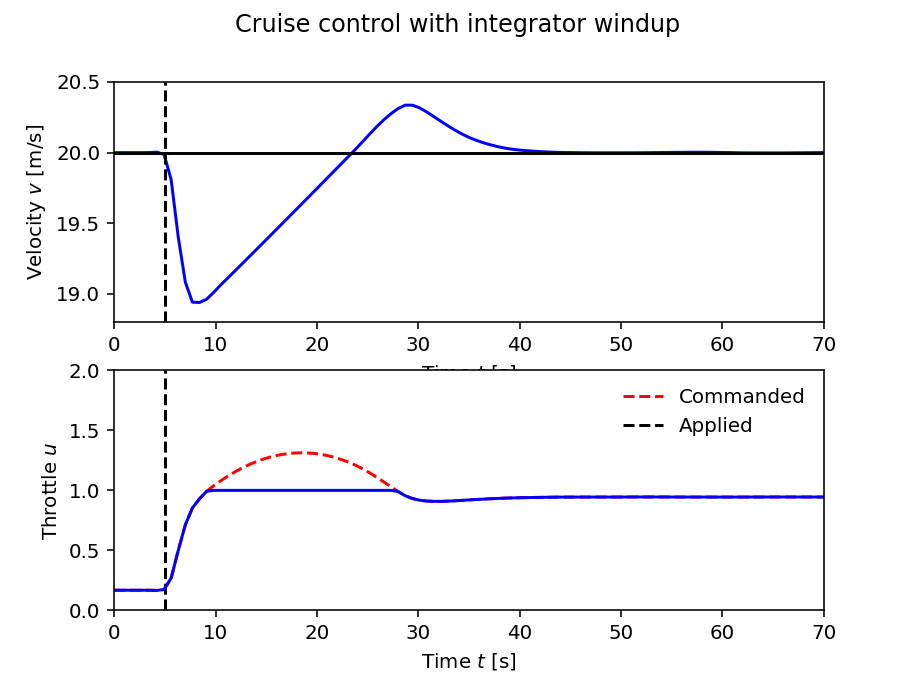

In [81]:
# Example 11.5: simulate the effect of a (steeper) hill at t = 5 seconds
#
# The windup effect occurs when a car encounters a hill that is so steep (6
# deg) that the throttle saturates when the cruise controller attempts to
# maintain speed.

plt.figure()
plt.suptitle('Cruise control with integrator windup')
T = np.linspace(0, 70, 101)
vref = 20 * np.ones(T.shape)
theta_hill = [
    0 if t <= 5 else
    6./180. * pi * (t-5) if t <= 6 else
    6./180. * pi for t in T]
t, y = ct.input_output_response(
    cruise_pi, T, [vref, gear, theta_hill], X0,
    params={'kaw':0})
cruise_plot(cruise_pi, t, y, antiwindup=True)

<IPython.core.display.Javascript object>


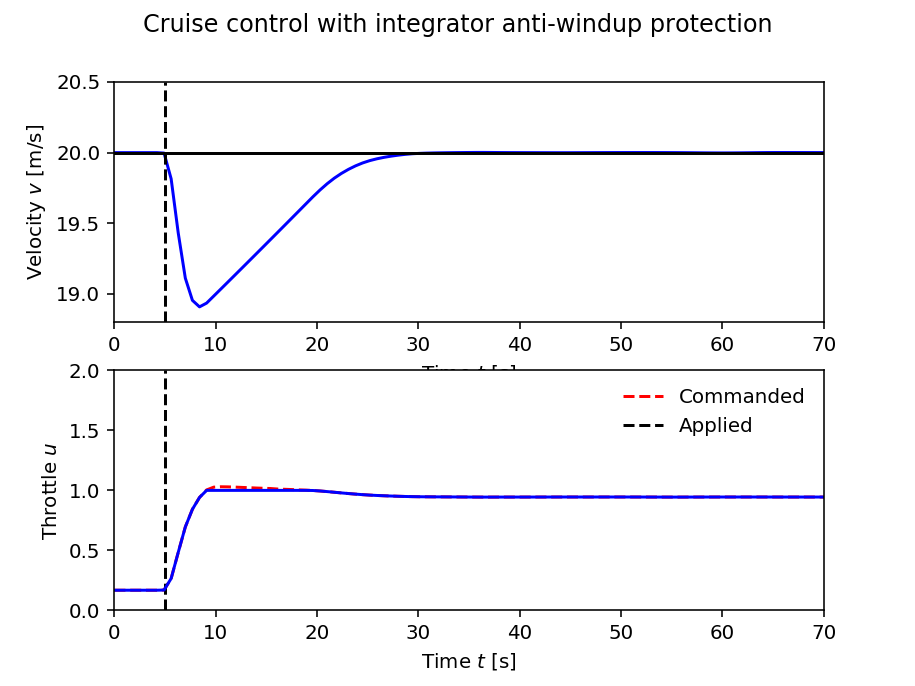

In [82]:
# Example 11.6: add anti-windup compensation
#
# Anti-windup can be applied to the system to improve the response. Because of
# the feedback from the actuator model, the output of the integrator is
# quickly reset to a value such that the controller output is at the
# saturation limit.

plt.figure()
plt.suptitle('Cruise control with integrator anti-windup protection')
t, y = ct.input_output_response(
    cruise_pi, T, [vref, gear, theta_hill], X0,
    params={'kaw':2.})
cruise_plot(cruise_pi, t, y, antiwindup=True)